# Identify STRs that are at splice sites
Like the ENCODE paper, define a splice site as being within 300bp of an exon. All of the following uses the GRCh37 alignments (GENCODE v19 annotations), also like the paper. 
Links to [GENCODE data](https://www.gencodegenes.org/human/release_37lift37.html)

In [2]:
import pyranges as pr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display all the columns of dataframes
pd.set_option('display.max_columns', None)

Load the STR data

In [3]:
col_names = ["Chromosome", "Start", "End", "class", 
            "length", "Strand", "num_units", 
            "actual_repeat", "gene_id", "gene_start",
            "gene_stop", "gene_strand", "annotation",
            "promoter", "dist_to_tss"]
dtype_dict = {"Chromosome": np.str, "Start":np.int, "End":np.int, "length": np.int, 
             "Strand": np.str} #, "gene_start": np.int, "gene_stop": np.int, "dist_to_tss": np.int}
str_df = pd.read_csv("data/msdb_data.tsv", sep = '\t', dtype = dtype_dict, names = col_names, index_col = False)
str_df.head()

/Users/david/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (9,10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss
0,chr1,10000,10108,AACCCT,108,+,18,TAACCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1766
1,chr1,10108,10149,AACCCT,41,+,6,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1725
2,chr1,10147,10179,AACCCT,32,+,5,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1695
3,chr1,10172,10184,AACCT,12,+,2,CCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1690
4,chr1,10177,10233,AACCCT,56,+,9,CCTAAC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1641


In [4]:
str_pr = pr.PyRanges(str_df)
str_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss
0,chr1,10000,10108,AACCCT,108,+,18,TAACCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1766
1,chr1,10108,10149,AACCCT,41,+,6,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1725
2,chr1,10147,10179,AACCCT,32,+,5,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1695
3,chr1,10172,10184,AACCT,12,+,2,CCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1690
4,chr1,10177,10233,AACCCT,56,+,9,CCTAAC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1641
5,chr1,10231,10249,AACCCT,18,+,3,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1625
6,chr1,10255,10290,AACCCT,35,+,5,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1584
7,chr1,10285,10326,AACCCC,41,+,6,AACCCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1548


Load the UCSC exons and introns

In [5]:
# col_names = ["Chromosome", "Start", "End", "ucsc_id", "Strand"]
# exon_df = pd.read_csv("data/ucsc_exons.bed", sep = '\t', names = col_names, index_col = False, skiprows = [0], usecols = [0,1,2,3,5])
# exon_pr = pr.PyRanges(exon_df)
gtf_pr = pr.read_gtf("data/hg19.knownGene.gtf")
exon_pr = gtf_pr[gtf_pr.Feature == "exon"]
exon_pr.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number,exon_id,gene_name
0,chr1,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN
1,chr1,knownGene,exon,12612,12721,.,+,.,uc001aaa.3,uc001aaa.3,2,uc001aaa.3.2,NaN
2,chr1,knownGene,exon,13220,14409,.,+,.,uc001aaa.3,uc001aaa.3,3,uc001aaa.3.3,NaN
3,chr1,knownGene,exon,11873,12227,.,+,.,uc010nxr.1,uc010nxr.1,1,uc010nxr.1.1,NaN
4,chr1,knownGene,exon,12645,12697,.,+,.,uc010nxr.1,uc010nxr.1,2,uc010nxr.1.2,NaN
5,chr1,knownGene,exon,13220,14409,.,+,.,uc010nxr.1,uc010nxr.1,3,uc010nxr.1.3,NaN
6,chr1,knownGene,exon,11873,12227,.,+,.,B7ZGX9,uc010nxq.1,1,uc010nxq.1.1,B7ZGX9
7,chr1,knownGene,exon,12594,12721,.,+,.,B7ZGX9,uc010nxq.1,2,uc010nxq.1.2,B7ZGX9


In [6]:
# col_names = ["Chromosome", "Start", "End", "ucsc_id", "Strand"]
# intron_df = pd.read_csv("data/ucsc_introns.bed", sep = '\t', names = col_names, index_col = False, skiprows = [0], usecols = [0,1,2,3,5])
# intron_pr = pr.PyRanges(intron_df)
intron_pr = gtf_pr.features.introns(by = "transcript")
intron_pr.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number,exon_id,gene_name
0,chr1,knownGene,intron,324060,324287,.,+,.,C9J4L2,uc001aau.3,NaN,NaN,C9J4L2
1,chr1,knownGene,intron,324345,324438,.,+,.,C9J4L2,uc001aau.3,NaN,NaN,C9J4L2
2,chr1,knownGene,intron,860569,861301,.,+,.,I7FV97,uc001abv.1,NaN,NaN,I7FV97
3,chr1,knownGene,intron,861393,865534,.,+,.,I7FV97,uc001abv.1,NaN,NaN,I7FV97
4,chr1,knownGene,intron,865716,866418,.,+,.,I7FV97,uc001abv.1,NaN,NaN,I7FV97
5,chr1,knownGene,intron,866469,871151,.,+,.,I7FV97,uc001abv.1,NaN,NaN,I7FV97
6,chr1,knownGene,intron,861180,861301,.,+,.,NP_689699,uc001abw.1,NaN,NaN,NP_689699
7,chr1,knownGene,intron,861393,865534,.,+,.,NP_689699,uc001abw.1,NaN,NaN,NP_689699


Next, get all the intervals of short tandem repeats that are intron-internal (in an intron and farther than 300 bp from a splice site):

In [7]:
# distance from all STRs to nearest exon
nearest_exon_pr = str_pr.nearest(exon_pr).sort()
nearest_exon_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss,Source,Feature,Start_b,End_b,Score,Strand_b,Frame,gene_id_b,transcript_id,exon_number,exon_id,gene_name,Distance
0,chr1,10000,10108,AACCCT,108,+,18,TAACCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1766,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1766
1,chr1,10108,10149,AACCCT,41,+,6,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1725,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1725
2,chr1,10147,10179,AACCCT,32,+,5,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1695,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1695
3,chr1,10172,10184,AACCT,12,+,2,CCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1690,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1690
4,chr1,10177,10233,AACCCT,56,+,9,CCTAAC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1641,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1641
5,chr1,10231,10249,AACCCT,18,+,3,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1625,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1625
6,chr1,10255,10290,AACCCT,35,+,5,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1584,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1584
7,chr1,10285,10326,AACCCC,41,+,6,AACCCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1548,knownGene,exon,11873,12227,.,+,.,uc001aaa.3,uc001aaa.3,1,uc001aaa.3.1,NaN,1548


In [9]:
# grab intron-annotated STRs and filter those with distance > 300bp
intron_internal_pr = nearest_exon_pr[(nearest_exon_pr.annotation == 'Intron') & (nearest_exon_pr.Distance > 300)].sort()
intron_internal_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss,Source,Feature,Start_b,End_b,Score,Strand_b,Frame,gene_id_b,transcript_id,exon_number,exon_id,gene_name,Distance
0,chr1,22811,22823,AAAGG,12,+,2,AGGAA,uc001aac.4,14362,29370,-,Intron,Non-Promoter,6547,knownGene,exon,24737,24891,.,-,.,uc009vir.3,uc009vir.3,9,uc009vir.3.9,NaN,1915
1,chr1,23874,23886,ACCTCC,12,+,2,CCTCCA,uc009viq.3,14362,29370,-,Intron,Non-Promoter,5484,knownGene,exon,24737,24891,.,-,.,uc009vir.3,uc009vir.3,9,uc009vir.3.9,NaN,852
2,chr1,669727,669739,AAC,12,+,4,AAC,uc009vjm.3,661139,670994,-,Intron,Non-Promoter,1255,knownGene,exon,668686,668744,.,-,.,B4DGA0,uc009vjm.3,2,uc009vjm.3.2,B4DGA0,984
3,chr1,676490,676503,AAAAG,13,+,2,AAAAG,uc001abm.2,674240,679736,-,Intron,Non-Promoter,3233,knownGene,exon,675508,675566,.,-,.,uc001abm.2,uc001abm.2,3,uc001abm.2.3,NaN,925
4,chr1,700958,700970,AAATAC,12,+,2,TACAAA,uc001abo.3,700245,714068,-,Intron,Non-Promoter,13098,knownGene,exon,700244,700627,.,-,.,uc001abo.3,uc001abo.3,1,uc001abo.3.1,NaN,332
5,chr1,701123,701136,A,13,+,13,A,uc001abo.3,700245,714068,-,Intron,Non-Promoter,12932,knownGene,exon,700244,700627,.,-,.,uc001abo.3,uc001abo.3,1,uc001abo.3.1,NaN,497
6,chr1,701240,701253,ACTCC,13,+,2,CCACT,uc001abo.3,700245,714068,-,Intron,Non-Promoter,12815,knownGene,exon,701708,701767,.,-,.,uc001abo.3,uc001abo.3,2,uc001abo.3.2,NaN,456
7,chr1,702159,702173,AATC,14,+,3,ATCA,uc001abo.3,700245,714068,-,Intron,Non-Promoter,11895,knownGene,exon,701708,701767,.,-,.,uc001abo.3,uc001abo.3,2,uc001abo.3.2,NaN,393


(array([1.311322e+06, 1.827140e+05, 7.396700e+04, 3.598300e+04,
        1.929500e+04, 1.112300e+04, 6.730000e+03, 4.103000e+03,
        2.812000e+03, 1.836000e+03, 1.260000e+03, 8.590000e+02,
        5.600000e+02, 4.270000e+02, 3.110000e+02, 2.250000e+02,
        2.070000e+02, 1.890000e+02, 1.680000e+02, 1.800000e+02,
        1.170000e+02, 6.100000e+01, 4.500000e+01, 3.700000e+01,
        6.300000e+01, 4.400000e+01, 6.000000e+01, 3.800000e+01,
        4.800000e+01, 4.100000e+01]),
 array([3.01000000e+02, 1.86616667e+04, 3.70223333e+04, 5.53830000e+04,
        7.37436667e+04, 9.21043333e+04, 1.10465000e+05, 1.28825667e+05,
        1.47186333e+05, 1.65547000e+05, 1.83907667e+05, 2.02268333e+05,
        2.20629000e+05, 2.38989667e+05, 2.57350333e+05, 2.75711000e+05,
        2.94071667e+05, 3.12432333e+05, 3.30793000e+05, 3.49153667e+05,
        3.67514333e+05, 3.85875000e+05, 4.04235667e+05, 4.22596333e+05,
        4.40957000e+05, 4.59317667e+05, 4.77678333e+05, 4.96039000e+05,
        5.

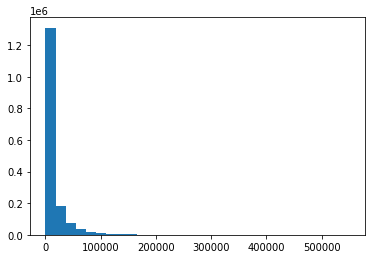

In [10]:
# make a histogram of the distances
fig, ax = plt.subplots()
ax.hist(intron_internal_pr.Distance, bins = 30)

Now, get the STRs that are within 300bp of a splice site:

In [11]:
# this means being within 300 bp of an intron AND 300 bp of an exon

# get all the intron coordinates and get the nearest intron to each STR
nearest_intron_pr = str_pr.nearest(intron_pr).sort()
nearest_intron_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss,Source,Feature,Start_b,End_b,Score,Strand_b,Frame,gene_id_b,transcript_id,exon_number,exon_id,gene_name,Distance
0,chr1,10000,10108,AACCCT,108,+,18,TAACCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1766,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,2120
1,chr1,10108,10149,AACCCT,41,+,6,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1725,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,2079
2,chr1,10147,10179,AACCCT,32,+,5,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1695,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,2049
3,chr1,10172,10184,AACCT,12,+,2,CCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1690,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,2044
4,chr1,10177,10233,AACCCT,56,+,9,CCTAAC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1641,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,1995
5,chr1,10231,10249,AACCCT,18,+,3,CCCTAA,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1625,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,1979
6,chr1,10255,10290,AACCCT,35,+,5,AACCCT,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1584,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,1938
7,chr1,10285,10326,AACCCC,41,+,6,AACCCC,uc001aaa.3,11874,14409,+,Intergenic,Non-Promoter,-1548,knownGene,intron,12227,12594,.,+,.,B7ZGX9,uc010nxq.1,NaN,NaN,B7ZGX9,1902


In [12]:
# remove the chromosomes that present in the exon PyRanges but not the introns
to_remove = list(set(nearest_exon_pr.Chromosome).difference(set(nearest_intron_pr.Chromosome)))
nearest_exon_pr = nearest_exon_pr[~nearest_exon_pr.Chromosome.isin(to_remove)]

# verify that the nearest_to pyranges are the same length and contain the same STRs
assert(len(nearest_intron_pr) == len(nearest_exon_pr))
assert((nearest_intron_pr.Chromosome == nearest_exon_pr.Chromosome).product() == 1)
assert((nearest_intron_pr.Start == nearest_exon_pr.Start).product() == 1)

In [13]:
within_300_pr = nearest_exon_pr[(nearest_exon_pr.Distance <= 300) & (nearest_intron_pr.Distance <= 300)].sort()
within_300_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss,Source,Feature,Start_b,End_b,Score,Strand_b,Frame,gene_id_b,transcript_id,exon_number,exon_id,gene_name,Distance
0,chr1,13623,13635,ACAGGC,12,+,2,CAGGCA,uc001aaa.3,11874,14409,+,Exon,Non-Promoter,1749,knownGene,exon,13220,14409,.,+,.,uc010nxr.1,uc010nxr.1,3,uc010nxr.1.3,NaN,0
1,chr1,322376,322388,AAGAAT,12,+,2,GAATAA,uc009vjk.2,322037,326938,+,Intron,Promoter,339,knownGene,exon,322036,322228,.,+,.,C9J4L2,uc009vjk.2,1,uc009vjk.2.1,C9J4L2,149
2,chr1,877247,877259,AGGGG,12,+,2,AGGGG,uc001abx.1,871152,879961,+,Intron,Non-Promoter,6095,knownGene,exon,877515,877631,.,+,.,H7BY14,uc031pjy.1,8,uc031pjy.1.8,H7BY14,257
3,chr1,879886,879906,AGCCC,20,+,4,CCAGC,uc001abx.1,871152,879961,+,Exon,Non-Promoter,8734,knownGene,exon,879287,879961,.,+,.,Q96NU1,uc031pjt.1,12,uc031pjt.1.12,Q96NU1,0
4,chr1,882085,882097,AGAGGC,12,+,2,GGCAGA,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11821,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,0
5,chr1,882362,882374,AGATGG,12,+,2,GGAGAT,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11544,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,0
6,chr1,882442,882456,ACT,14,+,4,TAC,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11462,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,3
7,chr1,888115,888127,ACCCCC,12,+,2,CCCCCA,uc001aby.4,879583,893918,-,Intron,Non-Promoter,5791,knownGene,exon,887791,887980,.,-,.,NP_056473,uc001abz.4,10,uc001abz.4.10,NP_056473,136


In [14]:
# make a new pyranges that has intron/exon annotation and distance to splice site (not just distance to intron or exon)
dist_to_exon = within_300_pr.Distance
dist_to_intron = nearest_intron_pr[(nearest_exon_pr.Distance <= 300) & (nearest_intron_pr.Distance <= 300)].Distance
assert(len(dist_to_exon) == len(dist_to_intron))
dist_to_ss = np.maximum(np.array(dist_to_exon), np.array(dist_to_intron))
within_300_pr.Distance = dist_to_ss

within_300_pr.head()

,Chromosome,Start,End,class,length,Strand,num_units,actual_repeat,gene_id,gene_start,gene_stop,gene_strand,annotation,promoter,dist_to_tss,Source,Feature,Start_b,End_b,Score,Strand_b,Frame,gene_id_b,transcript_id,exon_number,exon_id,gene_name,Distance
0,chr1,13623,13635,ACAGGC,12,+,2,CAGGCA,uc001aaa.3,11874,14409,+,Exon,Non-Promoter,1749,knownGene,exon,13220,14409,.,+,.,uc010nxr.1,uc010nxr.1,3,uc010nxr.1.3,NaN,222
1,chr1,322376,322388,AAGAAT,12,+,2,GAATAA,uc009vjk.2,322037,326938,+,Intron,Promoter,339,knownGene,exon,322036,322228,.,+,.,C9J4L2,uc009vjk.2,1,uc009vjk.2.1,C9J4L2,149
2,chr1,877247,877259,AGGGG,12,+,2,AGGGG,uc001abx.1,871152,879961,+,Intron,Non-Promoter,6095,knownGene,exon,877515,877631,.,+,.,H7BY14,uc031pjy.1,8,uc031pjy.1.8,H7BY14,257
3,chr1,879886,879906,AGCCC,20,+,4,CCAGC,uc001abx.1,871152,879961,+,Exon,Non-Promoter,8734,knownGene,exon,879287,879961,.,+,.,Q96NU1,uc031pjt.1,12,uc031pjt.1.12,Q96NU1,275
4,chr1,882085,882097,AGAGGC,12,+,2,GGCAGA,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11821,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,0
5,chr1,882362,882374,AGATGG,12,+,2,GGAGAT,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11544,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,0
6,chr1,882442,882456,ACT,14,+,4,TAC,uc001aby.4,879583,893918,-,Intron,Non-Promoter,11462,knownGene,exon,881781,882440,.,-,.,Q8NAK7,uc031pkq.1,5,uc031pkq.1.5,Q8NAK7,3
7,chr1,888115,888127,ACCCCC,12,+,2,CCCCCA,uc001aby.4,879583,893918,-,Intron,Non-Promoter,5791,knownGene,exon,887791,887980,.,-,.,NP_056473,uc001abz.4,10,uc001abz.4.10,NP_056473,136


(array([60717., 24545., 19964., 17836., 16487., 16799., 16497., 15794.,
        15242., 15142.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <BarContainer object of 10 artists>)

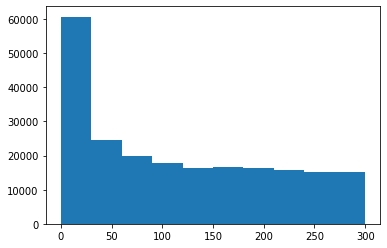

In [15]:
# histogram again
fig, ax = plt.subplots()
ax.hist(within_300_pr.Distance)

Then, visualize those that are in both introns and exons:

(array([34936., 24367., 19827., 17772., 16489., 16742., 16555., 15821.,
        15191., 14598.]),
 array([  1. ,  30.9,  60.8,  90.7, 120.6, 150.5, 180.4, 210.3, 240.2,
        270.1, 300. ]),
 <BarContainer object of 10 artists>)

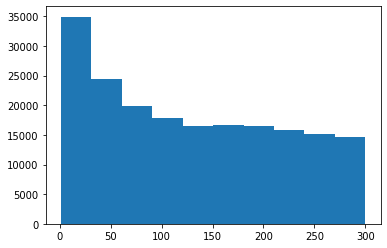

In [16]:
fig, ax = plt.subplots()
ax.hist(within_300_pr[within_300_pr.Distance != 0].Distance)